In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import invgamma
import pystan
import stan_utility
from statsmodels.stats.moment_helpers import cov2corr

ITER = 1000
SEED = 29042020

# 1) Gamma family distributions
## Gamma

In [4]:
with open('gamma_distr.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}

generated quantities {
  real out = gamma_rng(alpha, beta);
}


In [3]:
compiledModelGamma = stan_utility.compile_model('gamma_distr.stan')

Using cached StanModel


In [4]:
df = pd.DataFrame(columns = None)

# Generate samplings
for alpha in [1, 2, 7]:
    for beta in [1, 2, 7]:
        sim_uf = compiledModelGamma.sampling(data={'alpha': alpha,
                        'beta': beta}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
        samplName = "alpha={}_beta={}".format(alpha, beta)
        # zrobic + str(alpha)
        df[samplName] = sim_uf.extract()['out'] 

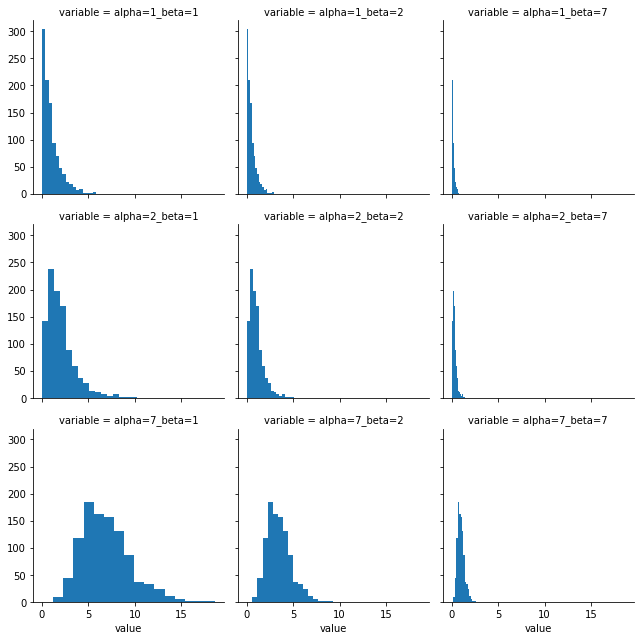

In [5]:
# Melt data frame to plot it
df_melted = df.melt()
fGrid=sns.FacetGrid(df_melted, col="variable", sharex=True, col_wrap=3)
fGrid.map(plt.hist, "value", cumulative=False, bins=16)

#### //The bigger is beta parameter the closer to zero are the samples. The bigger is alpha the bigger are the samples (further from zero). If alpha and beta are equal then the bigger they are the bigger is the mean of the distribution

## Inverted Gamma

In [6]:
with open('inv_gamma_distr.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}

generated quantities {
  real out = inv_gamma_rng(alpha, beta);
}



In [3]:
compiledModelInvGamma = stan_utility.compile_model('inv_gamma_distr.stan')

Using cached StanModel


In [6]:
df = pd.DataFrame(columns = None)

# Generate samplings
for alpha in [1, 2, 7]:
    for beta in [1, 2, 7]:
        sim_uf = compiledModelInvGamma.sampling(data={'alpha': alpha,
                        'beta': beta}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED-1)
        samplName = "alpha={}_beta={}".format(alpha, beta)
        df[samplName] = sim_uf.extract()['out'] 

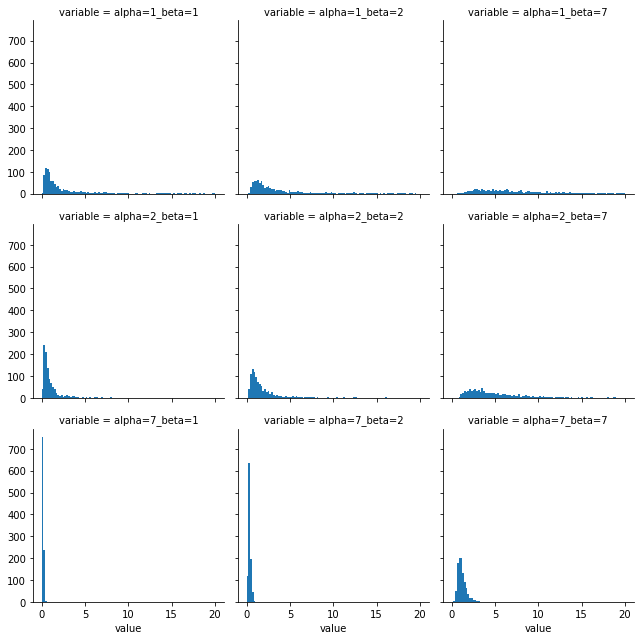

In [9]:
bins = np.linspace(0,20,100)
# Melt data frame to plot it
df_melted = df.melt()
fGrid=sns.FacetGrid(df_melted, col="variable", sharex=True, col_wrap=3)
fGrid.map(plt.hist, "value", cumulative=False, bins=bins)

#### //The bigger is alpha parameter the closer to zero are the samples. The bigger is beta the bigger are the samples (further from zero). If beta is much bigger than alpha the distribution is very wide.

## Find parameters for Gamma distribution

In [10]:
with open('gamma_find_params.stan', 'r') as file:
    print(file.read())

functions {
  vector gamma_delta(vector params, vector x, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = gamma_cdf(x[1], exp(params[1]), exp(params[2]))- 0.01;
    deltas[2] = gamma_cdf(x[2], exp(params[1]), exp(params[2]))- 0.99;
    return deltas;
  }
}

data {
  vector[2] alpha_beta_guess;
  vector[2] theta;   // Target quantiles
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(gamma_delta, alpha_beta_guess, theta, x_r, x_i);

}

generated quantities {
  real alpha = exp(y[1]);
  real beta = exp(y[2]);
}



In [11]:
compiledModel = stan_utility.compile_model('gamma_find_params.stan')

Using cached StanModel


In [14]:
alpha_init = 25
beta_init = 0.2
#98% of probability should be between 5 and 10:
x1 = 5
x2 = 10

In [15]:
sim_uf = compiledModel.sampling(data={'alpha_beta_guess': np.array([np.log(alpha_init), 
                                                          np.log(beta_init)]), 
                                      'theta': np.array([x1, x2])},                
                            algorithm="Fixed_param", iter=1,warmup=0, 
                            chains=1, refresh=1,seed=SEED)

In [16]:
alpha_out = sim_uf.extract()['alpha'][0]
beta_out = sim_uf.extract()['beta'][0]    
print('alpha: ',alpha_out)
print('beta: ',beta_out)

alpha:  45.63190460884883
beta:  6.279939507472603


In [17]:
sim_uf = compiledModelGamma.sampling(data={'alpha': alpha_out,
                        'beta': beta_out}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
results = sim_uf.extract()['out'] 

### Check if results are as expected

In [18]:
df = pd.DataFrame(results)

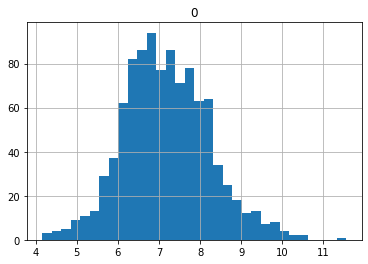

In [19]:
hist = df.hist(bins=32)

In [20]:
cntSamplesInRange_5_10 = 0
for sample in df[0]:
    if sample > 5 and sample < 10:
        cntSamplesInRange_5_10 +=1
percentageRange_5_10 = (cntSamplesInRange_5_10/df.size)*100

In [21]:
print("Percentage of samples being in range (5,10) = ",
      percentageRange_5_10, "%")

Percentage of samples being in range (5,10) =  97.89999999999999 %


## Find parameters for Inverse Gamma distribution

In [22]:
compiledModel = stan_utility.compile_model('inv_gamma_find_params.stan')

Using cached StanModel


In [23]:
alpha_init = 5
beta_init = 75
#98% of probability should be between 5 and 10:
theta_1 = 5
theta_2 = 10

In [24]:
# sampling from compiled stan model
sim_uf = compiledModel.sampling(data={'alpha_beta_guess': np.array([np.log(alpha_init), 
                                                          np.log(beta_init)]), 
                                      'theta': np.array([x1, x2])},                
                            algorithm="Fixed_param", iter=1,warmup=0, 
                            chains=1, refresh=1,seed=SEED)

In [25]:
alpha_out = sim_uf.extract()['alpha'][0]
beta_out = sim_uf.extract()['beta'][0]    
print('alpha: ',alpha_out)
print('beta: ',beta_out)

alpha:  45.631904608833366
beta:  313.99697537360476


In [26]:
sim_uf = compiledModelInvGamma.sampling(data={'alpha': alpha_out,
                        'beta': beta_out}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
results = sim_uf.extract()['out'] 

### Check if results are as expected

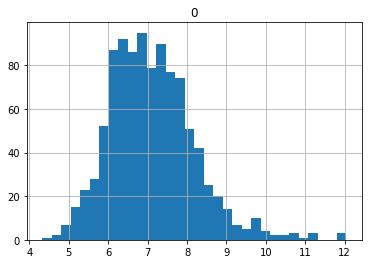

In [27]:
df = pd.DataFrame(results)
hist = df.hist(bins=32)

In [28]:
cntSamplesInRange_5_10 = 0
for sample in df[0]:
    if sample > 5 and sample < 10:
        cntSamplesInRange_5_10 +=1
percentageRange_5_10 = (cntSamplesInRange_5_10/df.size)*100

#### Compute accurate percentage:

In [29]:
print("Percentage of samples being in range (5,10) = ",
      percentageRange_5_10, "%")

Percentage of samples being in range (5,10) =  97.89999999999999 %


### Comparing histograms:
#### Histogram of inverse gamma distribution is shifted to the left (asymmetrical)

# 
# 2) Negative binomial and Poisson distribution
## 2 a) Dispersion parametrization

In [31]:
with open('neg_bin_and_poisson_Dispersion.stan', 'r') as file:
    print(file.read())

data {
    real mu;
    real phi;
}

generated quantities {
    real neg_bin = neg_binomial_2_rng (mu, phi);
    real poisson = poisson_rng(mu);
}



In [62]:
compiledModel = stan_utility.compile_model('neg_bin_and_poisson_Dispersion.stan')

Using cached StanModel


In [63]:
df_distr = pd.DataFrame(columns = None)

# Generate samplings
for mu in [1, 2, 7]:
    for phi in [1, 2, 7]:
        sim_uf = compiledModel.sampling(data={'mu': mu,
                        'phi': phi}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
        samplName = "mu={}_phi={}".format(mu, phi)
        df_distr[samplName] = sim_uf.extract()['neg_bin'] 
    samplName2 = "poisson_mu={}".format(mu)
    df_distr[samplName2] = sim_uf.extract()['poisson']

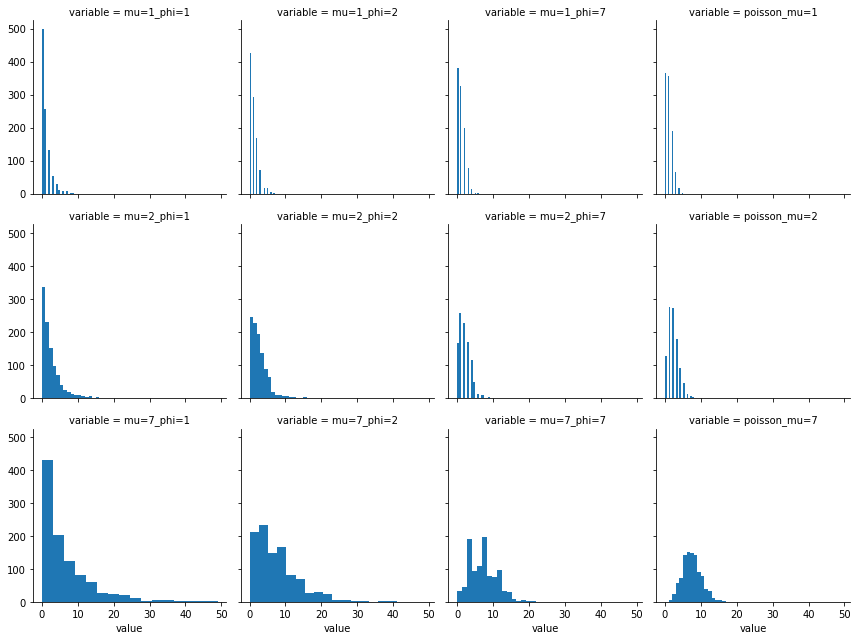

In [65]:
df_melted = df_distr.melt()
fGrid=sns.FacetGrid(df_melted, col="variable", sharex=True, col_wrap=4)
fGrid.map(plt.hist, "value", cumulative=False, bins=16)

#### //Poisson distribution in the last column - Neg bin distribution is similar to Poisson distribution with the same mean if phi is high. 

## 2 b)  Concentration parametrization

In [43]:
with open('neg_bin_and_poisson_Concentration.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real mu;
}

generated quantities {
    real neg_bin = neg_binomial_rng (alpha, alpha/mu);
    real poisson = poisson_rng(mu);
}



In [52]:
compiledModel = stan_utility.compile_model('neg_bin_and_poisson_Concentration.stan')

Using cached StanModel


In [55]:
df_distr = pd.DataFrame(columns = None)

# Generate samplings
for mu in [1, 2, 7]:
    for alpha in [2, 3, 10]:
        sim_uf = compiledModel.sampling(data={'mu': mu,
                        'alpha': alpha}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
        samplName = "mu={}_alpha={}".format(mu, alpha)
        df_distr[samplName] = sim_uf.extract()['neg_bin'] 
    samplName2 = "poisson_mu={}".format(mu)
    df_distr[samplName2] = sim_uf.extract()['poisson']

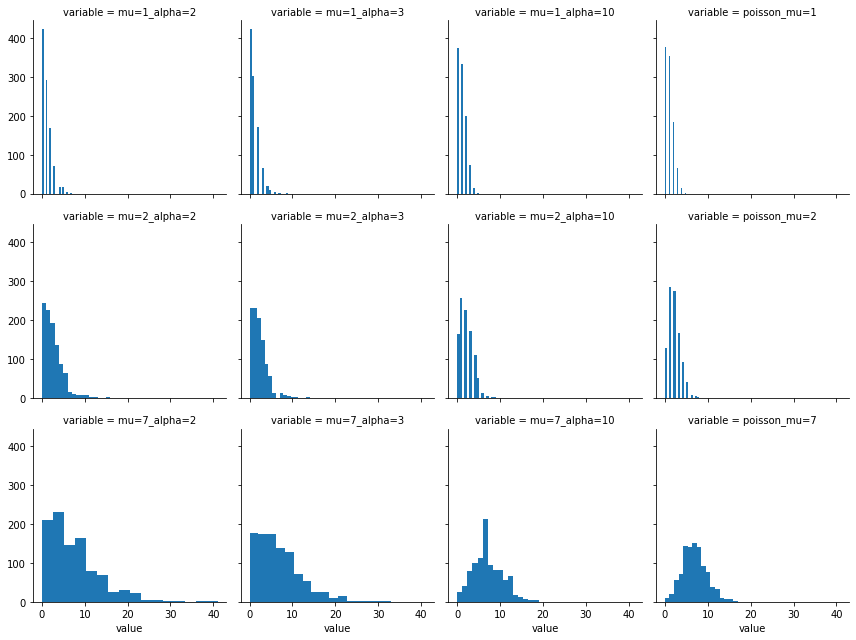

In [56]:
df_melted = df_distr.melt()
fGrid=sns.FacetGrid(df_melted, col="variable", sharex=True, col_wrap=4)
fGrid.map(plt.hist, "value", cumulative=False, bins=16)

#### //Poisson distribution in the last column - the same conclusion as before

# 
# 3) Student-t family distribution

In [68]:
with open('student_t_and_normal_distr.stan', 'r') as file:
    print(file.read())

data {
  real dof;
  real mu;
  real sigma;
}

generated quantities {
    real student = student_t_rng(dof, mu,sigma);
    real normal = normal_rng(mu,sigma);
}



In [104]:
compiledModel = stan_utility.compile_model('student_t_and_normal_distr.stan')

Using cached StanModel


In [87]:
df = pd.DataFrame(columns = None)
dof = 1 # dof = const =1
# Generate samplings
mu = 0
for sigma in [1, 3, 10]:
        sim_uf = compiledModel.sampling(data={'dof': dof,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=ITER, warmup=0, chains=1, 
                        refresh=ITER, seed=SEED)
        samplName = "student_mu={}_sigma={}".format(mu, sigma)
        df[samplName] = sim_uf.extract()['student'] 
        samplName2 = "normal_mu={}_sigma={}".format(mu, sigma)
        df[samplName2] = sim_uf.extract()['normal']

In [88]:
print(type(sim_uf))

<class 'stanfit4anon_model_a05007cfa733b0b1fd21c8e0e5aa9909_414683867367040939.StanFit4Model'>


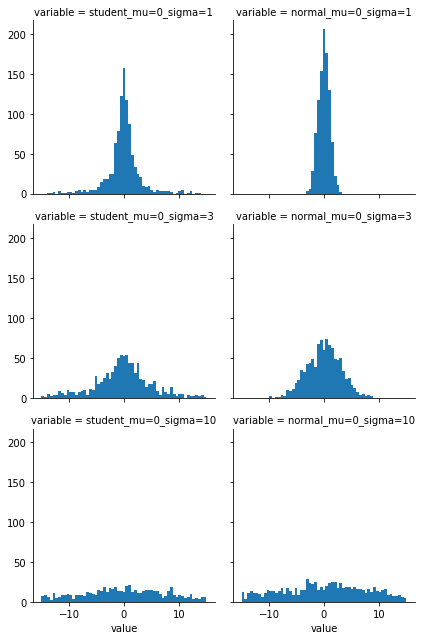

In [83]:
# Melt data frame to plot it
bins = np.linspace(-15,15,60)
df_melted = df.melt()
fGrid=sns.FacetGrid(df_melted, col="variable", sharex=True, col_wrap=2)
fGrid.map(plt.hist, "value", cumulative=False, bins=bins)

#### Samples from normal distribution are concentrated closer to the mean. The bigger ist the sigma parameter the more similar the distributions are.

#### Checking how mean and variance of student-t distribution depend on number of samples

In [112]:
d_means = {}
d_variances = {}
dof = 1 
mu = 0
sigma = 3
for nb_samples in [100,1000,10000,50000]:
        sim_uf = compiledModel.sampling(data={'dof': dof,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=nb_samples, warmup=0, chains=1, 
                        refresh=nb_samples, seed=SEED)
        d_means[nb_samples]= sim_uf.extract()['student'].mean()
        d_variances[nb_samples]=sim_uf.extract()['student'].var()

In [118]:
print('Number of samples, mean, variance:')
for k,v in d_means.items():
    print(k,v,d_variances[k])

Number of samples, mean, variance
100 16.5005295850424 14202.017522485774
1000 1.1014110798629193 2495.1462636955516
10000 0.6851113700060865 11567.71807622569
50000 5.102834567790968 781084.4704856034


#
# 4) Multivariate normal distribution

In [2]:
with open('multivar_normal_distr_N_dim.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] mu;
  matrix[N,N] sigma;
}

generated quantities {
    vector[N] y = multi_normal_rng(mu,sigma);
}



In [10]:
compiledModel = stan_utility.compile_model('multivar_normal_distr_N_dim.stan')

Using cached StanModel


## 4a) Bivariate normal distribution for const mean

In [58]:
df = pd.DataFrame(columns = None)
mu = [0, 0]
sigmas = [[[5, -2],[-2, 3]],
          [[5, -1],[-1, 3]],
          [[5, 0],[0, 3]],
          [[5, 1],[1, 3]],
          [[5, 2],[2, 3]],
          [[5, 3],[3, 3]]]
N = len(mu)

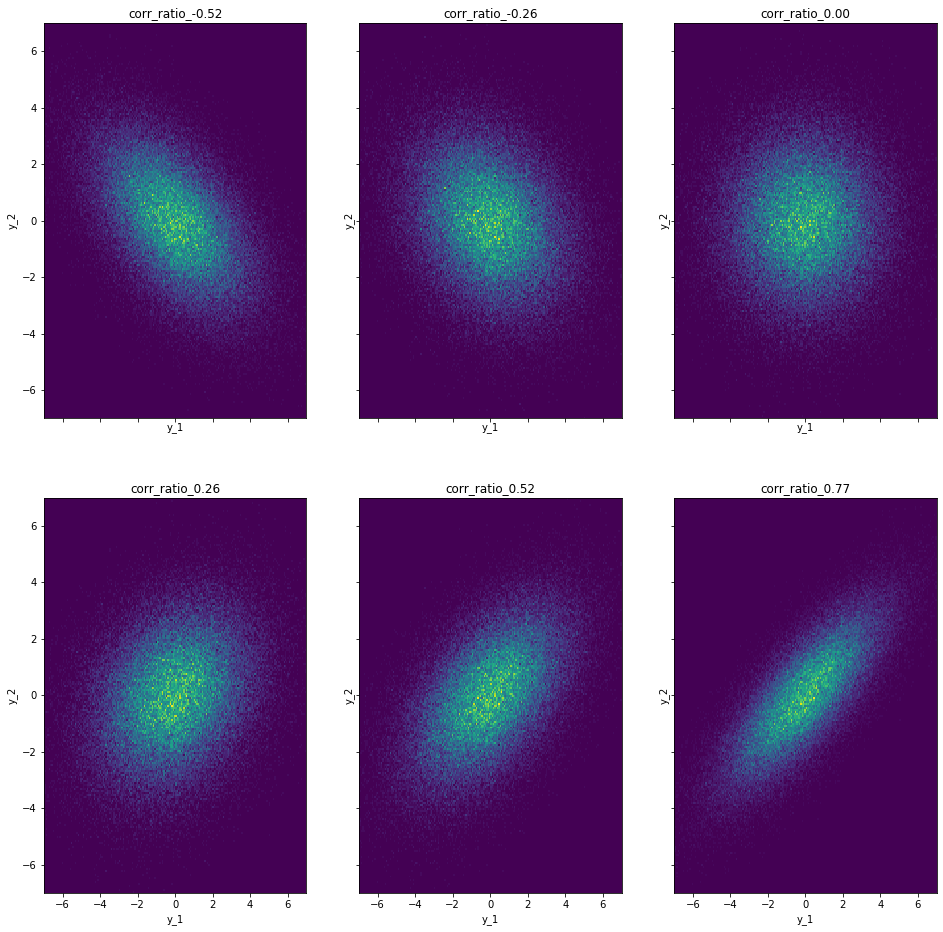

In [59]:
col_wrap = 3
fig, axes = plt.subplots(nrows=2, ncols=col_wrap,
                         sharex=True, sharey=True,
                         figsize=(16,16))
bins=np.linspace(-7,7,200)
i=j=0
for sigma in sigmas:
    sim_uf = compiledModel.sampling(data={'N': N,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=100*ITER, warmup=0, chains=1, 
                        refresh=100*ITER, seed=SEED+2)
    y = sim_uf.extract()['y']
    corr= cov2corr(sigma)
    axes[i,j].hist2d(y[:,0], y[:,1], bins=bins)
    axes[i,j].set_title('corr_ratio_{:.2f}'.format(corr[0,1]))   
    axes[i,j].set_xlim(-7, 7)
    axes[i,j].set_ylim(-7, 7)
    axes[i,j].set_xlabel('y_1')
    axes[i,j].set_ylabel('y_2')    
    if(j<col_wrap-1):
        j+=1
    else:
        j=0
        i+=1

#### //When correlation coefficient is a high positive number then y2 has high values for high values of y1 and low values for low values of y1. When correlation coefficient is a low negative number then behaviour of y2 is opposite: high values for low values of y1 etc.

In [60]:
df = pd.DataFrame(columns = None)
mu = [0, 0]
sigmas = [[[5, 2],[2, 1]],
          [[5, 2],[2, 2]],
          [[5, 2],[2, 5]],
          [[5, 2],[2, 10]]]
N = len(mu)

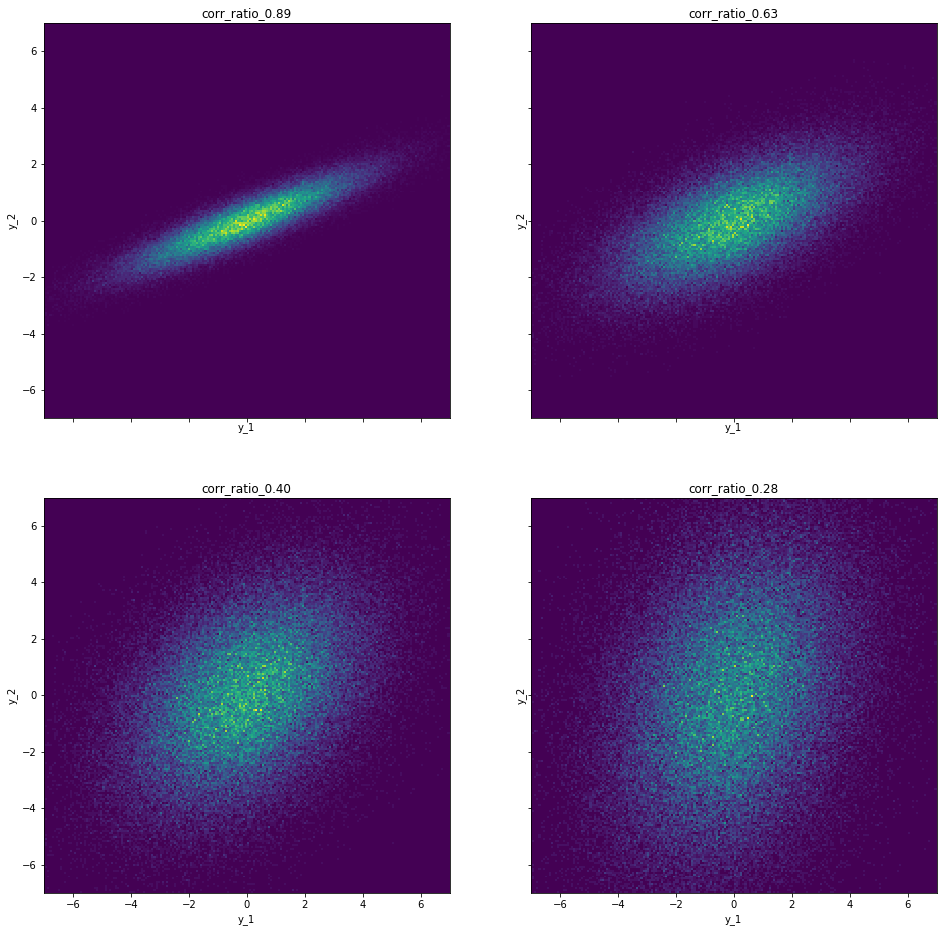

In [61]:
col_wrap = 2
fig, axes = plt.subplots(nrows=2, ncols=col_wrap,
                         sharex=True, sharey=True,
                         figsize=(16,16))
bins=np.linspace(-7,7,200)
i=j=0
for sigma in sigmas:
    sim_uf = compiledModel.sampling(data={'N': N,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=100*ITER, warmup=0, chains=1, 
                        refresh=100*ITER, seed=SEED+2)
    y = sim_uf.extract()['y']
    corr= cov2corr(sigma)
    axes[i,j].hist2d(y[:,0], y[:,1], bins=bins)
    axes[i,j].set_title('corr_ratio_{:.2f}'.format(corr[0,1]))   
    axes[i,j].set_xlim(-7, 7)
    axes[i,j].set_ylim(-7, 7)
    axes[i,j].set_xlabel('y_1')
    axes[i,j].set_ylabel('y_2')    
    if(j<col_wrap-1):
        j+=1
    else:
        j=0
        i+=1

## 4b) 3-dimensional normal distribution

In [20]:
df = pd.DataFrame(columns = None)
mu = [0, 0, 0]
sigma = [[1, 0.2, 0.7], [0.2, 1, 0.5],[0.7, 0.5, 8]]
N = len(mu)

In [21]:
corr= cov2corr(sigma)
corr

array([[1.        , 0.2       , 0.24748737],
       [0.2       , 1.        , 0.1767767 ],
       [0.24748737, 0.1767767 , 1.        ]])

Text(0, 0.5, 'y_3')

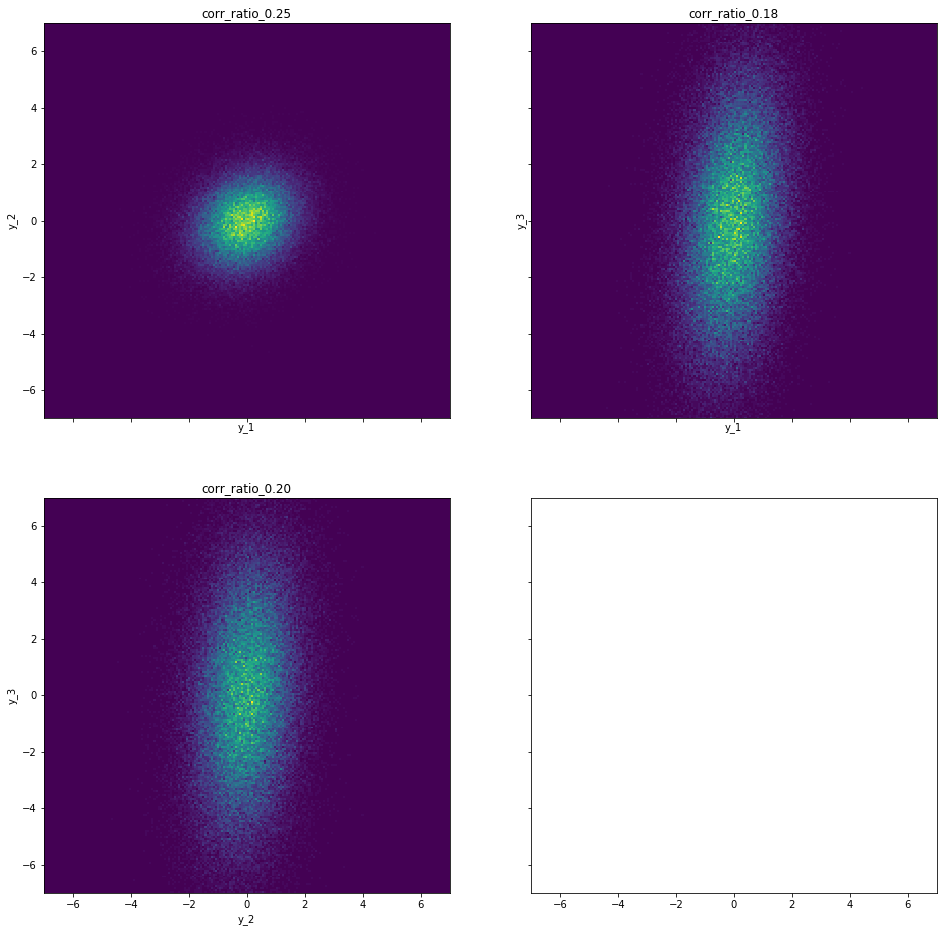

In [23]:
col_wrap = 2
fig, axes = plt.subplots(nrows=2, ncols=col_wrap,
                         sharex=True, sharey=True,
                         figsize=(16,16))
bins=np.linspace(-7,7,200)
i=j=0
sim_uf = compiledModel.sampling(data={'N': N,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=100*ITER, warmup=0, chains=1, 
                        refresh=100*ITER, seed=SEED+2)
y = sim_uf.extract()['y']

axes[0,0].hist2d(y[:,0], y[:,1], bins=bins)
axes[0,0].set_title('corr_ratio_{:.2f}'.format(corr[0,2]))   
axes[0,0].set_xlim(-7, 7)
axes[0,0].set_ylim(-7, 7)
axes[0,0].set_xlabel('y_1')
axes[0,0].set_ylabel('y_2')

axes[0,1].hist2d(y[:,0], y[:,2], bins=bins)
axes[0,1].set_title('corr_ratio_{:.2f}'.format(corr[1,2]))   
axes[0,1].set_xlim(-7, 7)
axes[0,1].set_ylim(-7, 7)
axes[0,1].set_xlabel('y_1')
axes[0,1].set_ylabel('y_3')  

axes[1,0].hist2d(y[:,1], y[:,2], bins=bins)
axes[1,0].set_title('corr_ratio_{:.2f}'.format(corr[1,0]))   
axes[1,0].set_xlim(-7, 7)
axes[1,0].set_ylim(-7, 7)
axes[1,0].set_xlabel('y_2')
axes[1,0].set_ylabel('y_3') 

In [29]:
mu = [0, 0, 0, 0]
sigma = [[1, 0.9, 0.4, 0.2], [0.9, 1, 0.8, 0.5],[0.4, 0.8, 5, 0.9], [0.2, 0.5, 0.9, 2]]
N = len(mu)

In [30]:
corr= cov2corr(sigma)
corr

array([[1.        , 0.9       , 0.17888544, 0.14142136],
       [0.9       , 1.        , 0.35777088, 0.35355339],
       [0.17888544, 0.35777088, 1.        , 0.28460499],
       [0.14142136, 0.35355339, 0.28460499, 1.        ]])

In [31]:
sim_uf = compiledModel.sampling(data={'N': N,'mu': mu,
                        'sigma': sigma}, algorithm="Fixed_param", 
                        iter=100*ITER, warmup=0, chains=1, 
                        refresh=100*ITER, seed=SEED+2)
y = sim_uf.extract()['y']

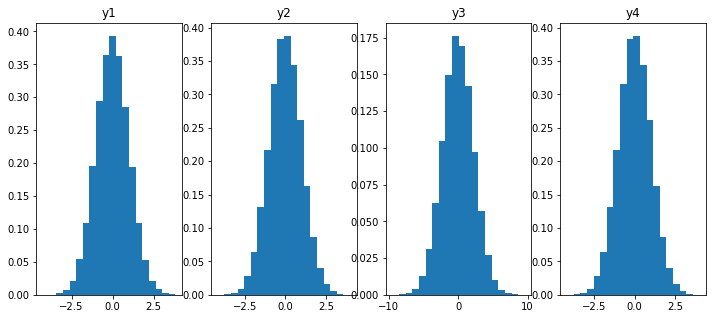

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))

axes[0].hist(y[:,0],bins=20,density=True)
axes[0].set_title('y1')

axes[1].hist(y[:,1],bins=20,density=True)
axes[1].set_title('y2')

axes[2].hist(y[:,2],bins=20,density=True)
axes[2].set_title('y3')

axes[3].hist(y[:,1],bins=20,density=True)
axes[3].set_title('y4')

plt.show()